In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path('data/labeled/')

In [3]:
batch_size = 32
img_height = 220
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # validation_split=0,
  # subset="training",
  # seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 409 files belonging to 16 classes.
Found 409 files belonging to 16 classes.
Using 40 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255,
                     input_shape=(img_height, img_width, 3),
                     name='input'),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
13/13 [==============================] - 3s 50ms/step - loss: 2.2987 - accuracy: 0.3741 - val_loss: 0.9204 - val_accuracy: 0.8500
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.5281 - accuracy: 0.8778 - val_loss: 0.3924 - val_accuracy: 0.8500
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 0.1666 - accuracy: 0.9535 - val_loss: 0.1763 - val_accuracy: 0.9500
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 0.0691 - accuracy: 0.9731 - val_loss: 0.1134 - val_accuracy: 0.9500
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 0.1522 - accuracy: 0.9804 - val_loss: 0.1864 - val_accuracy: 0.9500
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 0.0631 - accuracy: 0.9829 - val_loss: 0.1702 - val_accuracy: 0.9500
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 0.0304 - accuracy: 0.9927 - val_loss: 0.0276 - val_accuracy: 0.9750
Epoch 8/10
13

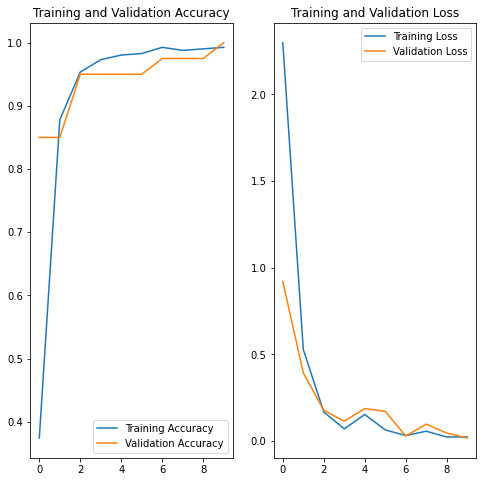

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
import json
json.dump(class_names, open('classifier_model/class_names.json', 'w'))

# !mkdir -p classifier_model
# model.save('classifier_model/')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\binux\AppData\Local\Temp\tmpp_7633gz\assets


INFO:tensorflow:Assets written to: C:\Users\binux\AppData\Local\Temp\tmpp_7633gz\assets
